# Time Series - ML Prediction

Using the dataset obtained from the Kaggle competition: https://www.kaggle.com/competitions/nuclio-dsc-str-1124

In this competition we will apply all the theoretical knowledge of Time Series and practice pandas and XGBoost with over 400 Time Series.

We need to beat the benchmark of:
- RMSE train = 2.6952017798866694
- RMSE test = 3.1366227889028027

## 1. Initialization

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [234]:
df = pd.read_csv('./ts_kaggle_train.csv', index_col = 0)

In [235]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0


In [236]:
df.shape

(14484, 8)

In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   14484 non-null  object 
 1   unique_id              14484 non-null  object 
 2   city_id                14484 non-null  int64  
 3   shop_id                14484 non-null  int64  
 4   item_category_id       14484 non-null  int64  
 5   item_id                14484 non-null  int64  
 6   monthly_average_price  13262 non-null  float64
 7   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 1.5+ MB


In [238]:
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

In [239]:
df.sort_values(["date", "unique_id"], inplace=True)

In [240]:
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0
...,...,...,...,...,...,...,...,...
14479,2015-10-31,7_5822,21,7,35,5822,NaN,NaN
14480,2015-10-31,7_6185,21,7,30,6185,NaN,NaN
14481,2015-10-31,7_6497,21,7,28,6497,NaN,NaN
14482,2015-10-31,7_7856,21,7,28,7856,NaN,NaN


## 2. Nulls

In [241]:
df.isnull().sum()

,0
date,0
unique_id,0
city_id,0
shop_id,0
item_category_id,0
item_id,0
monthly_average_price,1222
monthly_sales,728


In [242]:
df['unique_id'].nunique()

426

In [243]:
stranger_values = {}
for unique_id in df['unique_id'].unique():
  Q_nulls = df[df['unique_id'] == unique_id]['monthly_sales'].isnull().sum()
  Q_zero = (df[df['unique_id'] == unique_id]['monthly_sales'] == 0).sum()
  P_nulls = df[df['unique_id'] == unique_id]['monthly_average_price'].isnull().sum()
  P_zero = (df[df['unique_id'] == unique_id]['monthly_average_price'] == 0).sum()

  if Q_nulls > 0 or Q_zero > 0 or P_nulls > 0 or P_zero > 0:
    stranger_values[unique_id] = [Q_nulls, Q_zero, P_nulls, P_zero]
df_strager_values = pd.DataFrame(stranger_values).T

In [244]:
df_strager_values.columns = ['Q_nulls', 'Q_zero', 'P_nulls', 'P_zero']
df_strager_values

,Q_nulls,Q_zero,P_nulls,P_zero
12_11365,1,0,1,0
12_11369,1,0,1,0
12_11370,1,0,1,0
12_11373,1,0,1,0
12_12231,1,1,2,0
...,...,...,...,...
7_5822,1,0,1,0
7_6185,1,2,3,0
7_6497,5,0,5,0
7_7856,1,1,2,0


In [245]:
df_strager_values['Q_nulls'].sum()

np.int64(728)

In [246]:
df_strager_values['Q_nulls'].sum()

np.int64(728)

In [247]:
df_strager_values['P_nulls'].min()

1

In [248]:
df_strager_values['Q_zero'].sum()

np.int64(497)

In [249]:
df[df['unique_id'] == '7_6185']

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
14084,2013-01-31,7_6185,21,7,30,6185,499.000000,7.0
14096,2013-02-28,7_6185,21,7,30,6185,499.000000,10.0
14108,2013-03-31,7_6185,21,7,30,6185,499.000000,3.0
14120,2013-04-30,7_6185,21,7,30,6185,499.000000,1.0
14132,2013-05-31,7_6185,21,7,30,6185,499.000000,1.0
14144,2013-06-30,7_6185,21,7,30,6185,499.000000,3.0
14156,2013-07-31,7_6185,21,7,30,6185,499.000000,3.0
14168,2013-08-31,7_6185,21,7,30,6185,499.000000,7.0
14180,2013-09-30,7_6185,21,7,30,6185,499.000000,2.0
14192,2013-10-31,7_6185,21,7,30,6185,498.940000,6.0


In [250]:
df[df['monthly_average_price'].isnull()][df['monthly_sales'].isnull()].shape

/tmp/ipython-input-2121786151.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['monthly_average_price'].isnull()][df['monthly_sales'].isnull()].shape


(728, 8)

In [251]:
494+728

1222

In [252]:
# identificamos por unique_id la fecha mas antigua donde monthly_sales es no nulo

(
 df
 [df['monthly_sales'].notnull()]
 .groupby('unique_id')['date'].min()
 # [['date'] > '2013-01-31'] # Original incorrect line
 [lambda x: x > '2013-01-31'] # Corrected line
 .shape
)

(133,)

In [253]:

df.groupby('unique_id')['monthly_average_price'].nunique()

,monthly_average_price
unique_id,
12_11365,33
12_11369,33
12_11370,33
12_11373,33
12_12231,1
...,...
7_5822,9
7_6185,3
7_6497,16


In [254]:
df[df['monthly_average_price'].notnull()][df['monthly_sales'] == 0]['unique_id']

/tmp/ipython-input-3022368022.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['monthly_average_price'].notnull()][df['monthly_sales'] == 0]['unique_id']


,unique_id
3447,25_5459
7072,31_9507
1737,19_7894


<Axes: xlabel='monthly_average_price'>

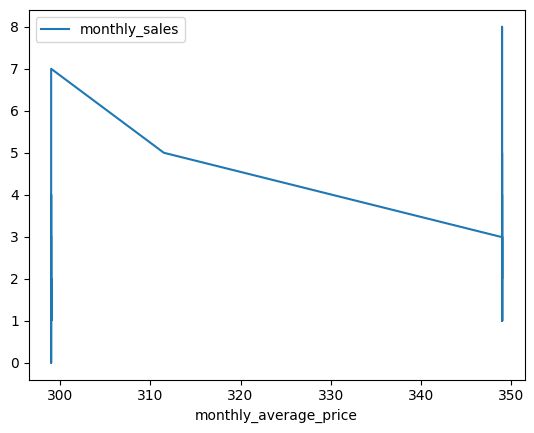

In [255]:
(

 df
 [df['unique_id'] == '25_5459']
 [['monthly_average_price', 'monthly_sales']]
 .set_index('monthly_average_price')
 .sort_index()
 .plot()
 )

#### Tratamiento de P y Q nulos

In [256]:
#### P y Q nulos: solo cuando P es null Q es null o es 0
#### Q es null al inicio de la serie o al final de la serie (valores a pronosticar), en el medio de la serie es 0

In [257]:
#Estrategia de imputacion:
# - registros antiguos donde P es null y Q es null: drop
# - registros donde P es null y Q es 0 interpolate Q e interpolate P
# - registros recientes donde P es null y Q es null - son registros futuros a pronosticar : frontfill P, dejar Q null

In [258]:
df['date'].max()

Timestamp('2015-10-31 00:00:00')

In [259]:
# Separamos registros futuros a pronosticar:
df_future = df[df['date'] > pd.to_datetime('2015-09-30')]

In [260]:
df_future.shape

(426, 8)

In [261]:
# Eliminamos del df registros futuros
df = df[df['date'] <= pd.to_datetime('2015-09-30')]

In [262]:
df.shape

(14058, 8)

In [263]:
# Eliminamos registros antiguos donde P y Q son null
df = df[~((df['monthly_average_price'].isnull()) & (df['monthly_sales'].isnull()))]

In [264]:
df.shape

(13756, 8)

In [265]:
#Hacemos null los valores de Q donde P es null
df.loc[df['monthly_average_price'].isnull(), 'monthly_sales'] = np.nan

In [266]:
#Anexamos los valores futuros para completar el df e imputar
df = pd.concat([df, df_future])

In [267]:




df["monthly_average_price"] = (
    df
    .groupby(["unique_id"])
    ["monthly_average_price"]
    .transform(
        lambda series: series.interpolate().bfill().ffill()
    )
)

In [268]:
df.isnull().sum()

,0
date,0
unique_id,0
city_id,0
shop_id,0
item_category_id,0
item_id,0
monthly_average_price,0
monthly_sales,920


In [269]:

df["monthly_sales"] = (
    df
    .groupby(["unique_id"])
    ["monthly_sales"]
    .transform(
        lambda series: series.interpolate().bfill().ffill()
    )
)

In [270]:
# Fill NAs with 0
#df["monthly_sales"].fillna(0, inplace = True)

In [271]:
df.isnull().sum()

,0
date,0
unique_id,0
city_id,0
shop_id,0
item_category_id,0
item_id,0
monthly_average_price,0
monthly_sales,0


## Funciones

In [272]:
"""

#nombres de columnas del df
columnas_df = df.columns.tolist()

#diccionario de transformaciones de nombres
dict_sufijos_transformaciones = {1: [[(columnas_a_imputar_moda, 'imputer_moda'), (columnas_a_imputar_mediana, 'imputer_mediana'), (columnas_a_imputar_media, 'imputer_media') ,(columnas_a_imputar_otros, 'imputer_otros'), (columnas_a_imputar_cero, 'imputer_cero')], 'remainder'],
                                 2: [[(list_columnas_a_resumir_categorias_original, 'main_categories'), (columnas_a_aplicar_frecuency_encoding_original, 'frecuency_encoding'),(columnas_a_aplicar_agrupamiento_target_encoding_original, 'pre_target_encoding') ], 'remainder'],
                                 3: [[(columnas_a_aplicar_OHE_original, 'one_hot_encoding'), (columnas_a_aplicar_target_encoding_original, 'target_encoding'), (columnas_a_transformar_binarias_original, 'binaria'), (columnas_a_transformar_ordinal_original, 'ordinal')], 'remainder']}

"""

"\n\n#nombres de columnas del df\ncolumnas_df = df.columns.tolist()\n\n#diccionario de transformaciones de nombres\ndict_sufijos_transformaciones = {1: [[(columnas_a_imputar_moda, 'imputer_moda'), (columnas_a_imputar_mediana, 'imputer_mediana'), (columnas_a_imputar_media, 'imputer_media') ,(columnas_a_imputar_otros, 'imputer_otros'), (columnas_a_imputar_cero, 'imputer_cero')], 'remainder'],\n                                 2: [[(list_columnas_a_resumir_categorias_original, 'main_categories'), (columnas_a_aplicar_frecuency_encoding_original, 'frecuency_encoding'),(columnas_a_aplicar_agrupamiento_target_encoding_original, 'pre_target_encoding') ], 'remainder'],\n                                 3: [[(columnas_a_aplicar_OHE_original, 'one_hot_encoding'), (columnas_a_aplicar_target_encoding_original, 'target_encoding'), (columnas_a_transformar_binarias_original, 'binaria'), (columnas_a_transformar_ordinal_original, 'ordinal')], 'remainder']}\n\n"

In [273]:
# Generamos una funcion para formar un diccionario con los nombres de las columnas actualizados con los sufijos de las transformaciones

def cambiar_nombre_columna(lista_columna, prefijo_transofmer):
    nombres_nuevas_columna = []
    for columna in lista_columna:
        nuevas_columna.append(prefijo_transofmer + '__' + columna)
    return nuevas_columna

In [274]:
# Generamos DF de nombre original (columna), nombre_1 (sufijo_1__columna), nombre_2, etc

def genera_df_nombres_pipeline(columnas_df, dict_sufijos_transformaciones):
  df_nombres_pipeline = pd.DataFrame(columns = ['nombre_original'])
  df_nombres_pipeline['nombre_original'] = columnas_df
  df_nombres_pipeline.astype(str)
  # recorremos los step del pipeline
  for n_step, transformaciones in dict_sufijos_transformaciones.items():
    columna_df = 'nombre_' + str(n_step)
    df_nombres_pipeline[columna_df] = ''
    # recorremos las transformaciones de cada step
    for columna in transformaciones[0]:
      # aplicamos el sufijo de la tupla a las columnas de la lista
      sufijo = columna[1]
      for columna_transform in columna[0]:
        #ya tenemos el sufijo de la transformacion
        #ya tenemos uno a uno la columna que se va a aplicar esta transofmacion
        if n_step == 1:
          nuevo_nombre_columna = sufijo + '__' + columna_transform
        else:
          nombre_anterior = df_nombres_pipeline[df_nombres_pipeline['nombre_original'] == columna_transform]['nombre_' + str(n_step - 1)].values[0]
          nuevo_nombre_columna = sufijo + '__' + nombre_anterior

        #Incluimos nuevo_nombre_columna en columna_df donde nombre_original coincide con column_transform
        df_nombres_pipeline.loc[df_nombres_pipeline['nombre_original'] == columna_transform, columna_df] = nuevo_nombre_columna


    # terminadas las transformaciones aplicamos el drop o remainder a las columnas restantes
    if transformaciones[1] == 'drop':
      # eliminamos filas donde df_nombres_pipeline[columna_df] es vacio (drop columnas)
      df_nombres_pipeline = df_nombres_pipeline[df_nombres_pipeline[columna_df] != '']
    if transformaciones[1] == 'remainder':
      # aplicamos el sufijo remainder donde df_nombres_pipeline[columna_df] es vacio
      sufijo = 'remainder__'
      if n_step == 1:
        df_nombres_pipeline.loc[df_nombres_pipeline[columna_df] == '', columna_df] = sufijo + df_nombres_pipeline['nombre_original']
      else:
        df_nombres_pipeline.loc[df_nombres_pipeline[columna_df] == '', columna_df] = sufijo + df_nombres_pipeline['nombre_' + str(n_step - 1)]

  return df_nombres_pipeline

## 3. EDA

<Axes: xlabel='monthly_sales'>

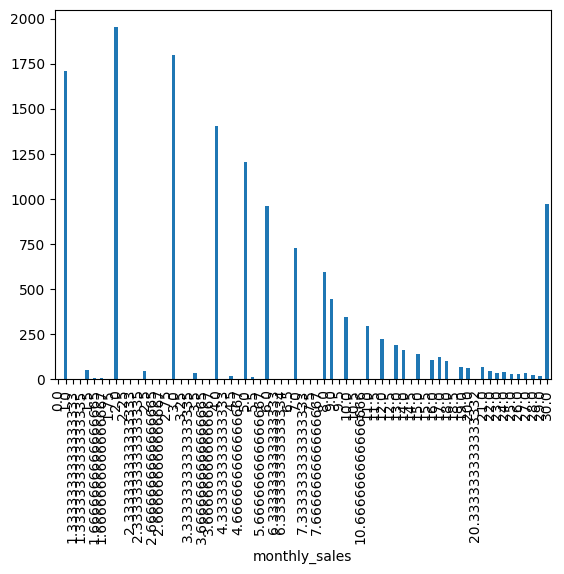

In [275]:
df["monthly_sales"].value_counts().sort_index().plot(kind = "bar")

<Axes: xlabel='shop_id'>

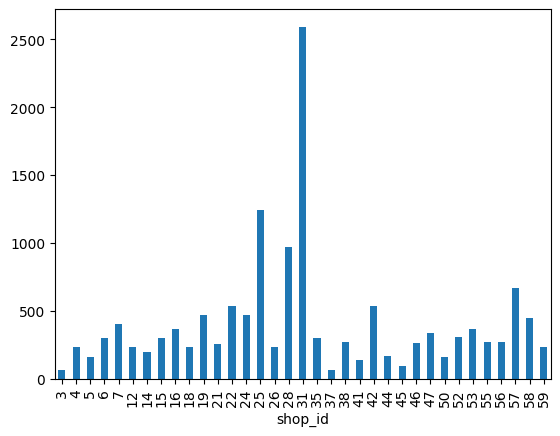

In [276]:


df["shop_id"].value_counts().sort_index().plot(kind = "bar")

<Axes: xlabel='city_id'>

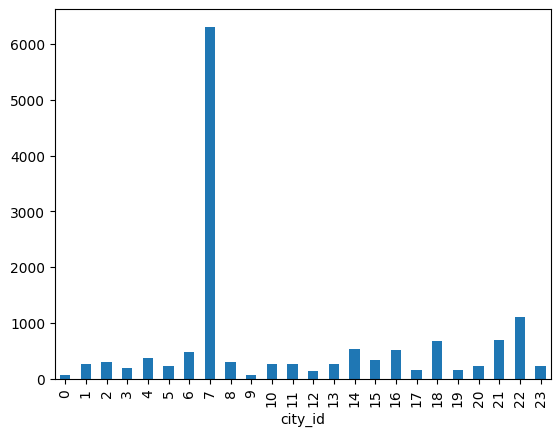

In [277]:
df["city_id"].value_counts().sort_index().plot(kind = "bar")

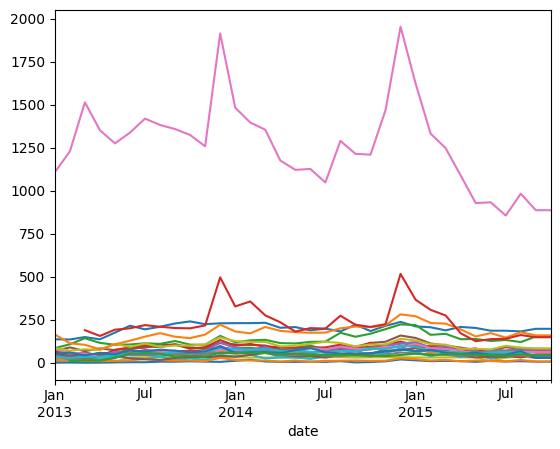

In [278]:
for i in df.city_id.unique():
    t = (
    df[df.city_id == i]
    .groupby(["date"])
    ["monthly_sales"]
    .sum()
    )
    t.plot()

/tmp/ipython-input-527356016.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


<Axes: xlabel='date'>

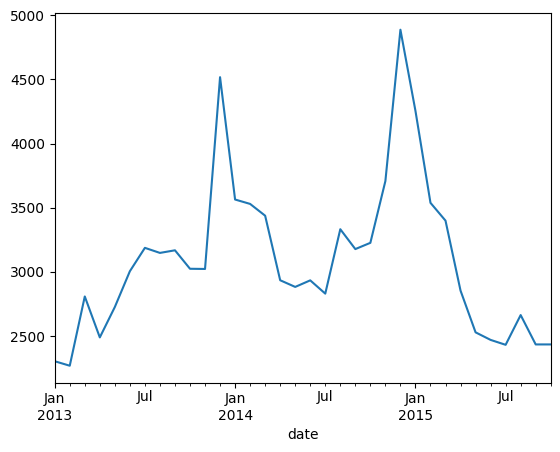

In [279]:
# resample
t = (
    df
    .set_index("date")
    .resample("M")
    ["monthly_sales"]
    .sum()
)
t.plot()

<Axes: xlabel='date'>

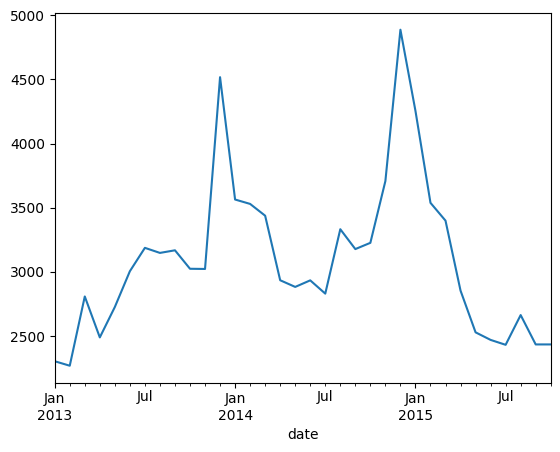

In [280]:
t = (
    df
    .groupby(["date"])
    ["monthly_sales"]
    .sum()
)
t.plot()

In [281]:
df.item_category_id.value_counts()

,count
item_category_id,
30,2883
35,2482
6,1144
40,906
55,881
71,701
28,692
65,690
23,668


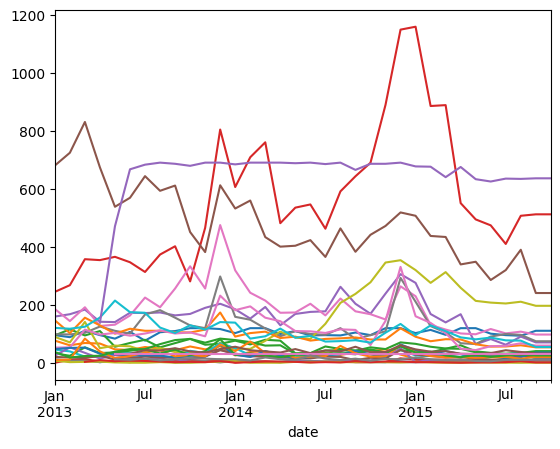

In [282]:
for i in df.item_category_id.unique():
    t = (
    df[df.item_category_id == i]
    .groupby(["date"])
    ["monthly_sales"]
    .sum()
    )
    t.plot()
    #TODO Agregar leyenda

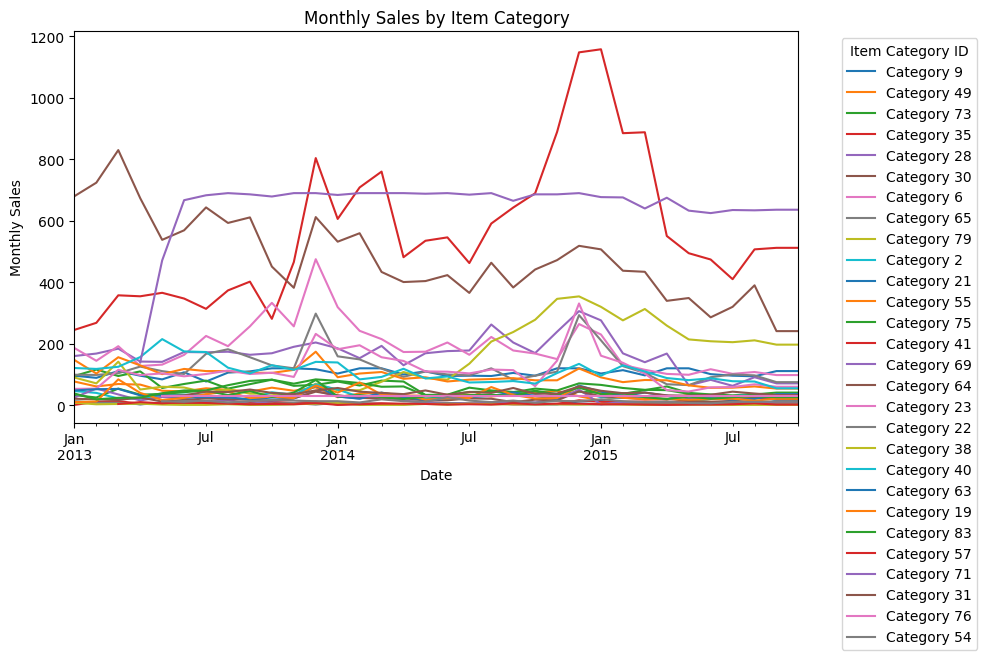

In [283]:
plt.figure(figsize=(10,6))

for i in df.item_category_id.unique():
    t = (
        df[df.item_category_id == i]
        .groupby(["date"])["monthly_sales"]
        .sum()
    )
    t.plot(label=f'Category {i}')

plt.legend(title="Item Category ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Date")
plt.ylabel("Monthly Sales")
plt.title("Monthly Sales by Item Category")
plt.tight_layout()  # 🔹 Ajusta márgenes automáticamente
plt.show()

<Axes: xlabel='monthly_sales', ylabel='monthly_average_price'>

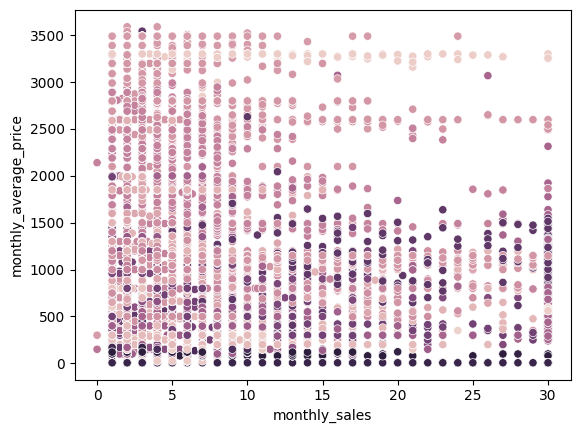

In [284]:
sns.scatterplot(df[df["monthly_average_price"] < 4000],
                x = "monthly_sales",
                y = "monthly_average_price",
                hue = "item_id",
                legend=None)

In [285]:
df["item_category_id"].unique()

array([ 9, 49, 73, 35, 28, 30,  6, 65, 79,  2, 21, 55, 75, 41, 69, 64, 23,
       22, 38, 40, 63, 19, 83, 57, 71, 31, 76, 54])

In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14182 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14182 non-null  datetime64[ns]
 1   unique_id              14182 non-null  object        
 2   city_id                14182 non-null  int64         
 3   shop_id                14182 non-null  int64         
 4   item_category_id       14182 non-null  int64         
 5   item_id                14182 non-null  int64         
 6   monthly_average_price  14182 non-null  float64       
 7   monthly_sales          14182 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 997.2+ KB


<Axes: xlabel='date', ylabel='monthly_sales'>

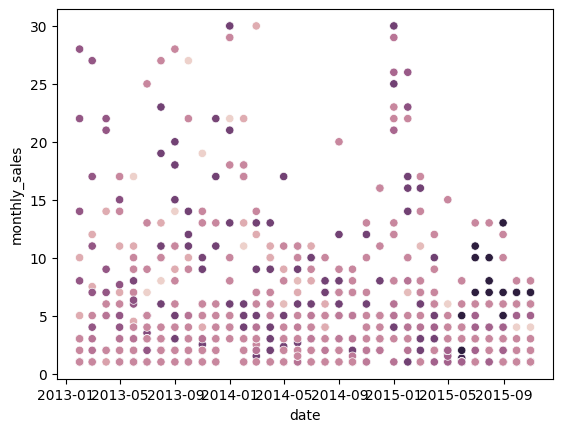

In [287]:
list_test = pd.DataFrame(df.item_id.unique())
list_test.sample(5)
sns.scatterplot(df[df["item_category_id"] == 65],
                x = "date",
                y = "monthly_sales",
                hue = "monthly_average_price",
                legend=None)

In [288]:
df.item_category_id

,item_category_id
0,9
1,9
2,9
3,9
4,49
...,...
14479,35
14480,30
14481,28
14482,28


In [289]:
df[df["monthly_average_price"] > 4000]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
56,2013-09-30,12_11365,16,12,9,11365,9305.121212,24.0


In [290]:
df[df["unique_id"] == "12_11365"]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0
35,2013-06-30,12_11365,16,12,9,11365,1302.343750,28.0
42,2013-07-31,12_11365,16,12,9,11365,1736.785714,20.0
49,2013-08-31,12_11365,16,12,9,11365,3072.361111,16.0
56,2013-09-30,12_11365,16,12,9,11365,9305.121212,24.0
63,2013-10-31,12_11365,16,12,9,11365,2493.113360,30.0


In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14182 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14182 non-null  datetime64[ns]
 1   unique_id              14182 non-null  object        
 2   city_id                14182 non-null  int64         
 3   shop_id                14182 non-null  int64         
 4   item_category_id       14182 non-null  int64         
 5   item_id                14182 non-null  int64         
 6   monthly_average_price  14182 non-null  float64       
 7   monthly_sales          14182 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 997.2+ KB


## Ventas negativas

In [292]:
df[df["monthly_sales"] < 0]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales


In [293]:
### Brainstorming de features

# Fequency Encoding - city ID / shop_id
# date
# AR: 1Y, 1D, 6M, 1M - ver como imputar nulos en los datos que nos faltan al principio de la serie
# COUNT del item por tienda - ver si un producto general o particular - tienda grande / especializada
# COUNT de item_id por item_category - categorias grandes vs pequeñas
# COUNT de item_id por city_id
# COUNT de shop_id por city_id
# Grupos caros / baratos ABC
# Grupos que se venden mucho / poco

## Features

In [294]:
#TODO
# Media de precios por categoria, por ciudad, por tienda, por mes, por item

### Fequency Encoding - city ID / shop_id

In [295]:
# Fequency Encoding - city ID / shop_id
df_features = df.copy()

for col in ['city_id', 'shop_id', 'item_id']:
    freq_encoding = df_features[col].value_counts(normalize=True)
    df_features[f'{col}_freq_enc'] = df_features[col].map(freq_encoding)

df_features[['city_id', 'city_id_freq_enc', 'shop_id', 'shop_id_freq_enc']].head()

,city_id,city_id_freq_enc,shop_id,shop_id_freq_enc
0,16,0.03582,12,0.016782
1,16,0.03582,12,0.016782
2,16,0.03582,12,0.016782
3,16,0.03582,12,0.016782
4,16,0.03582,12,0.016782


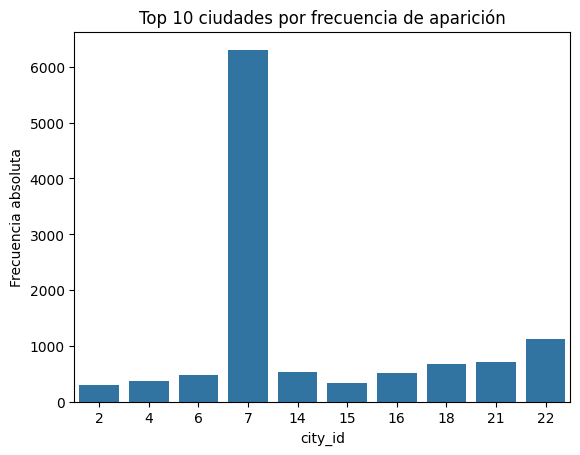

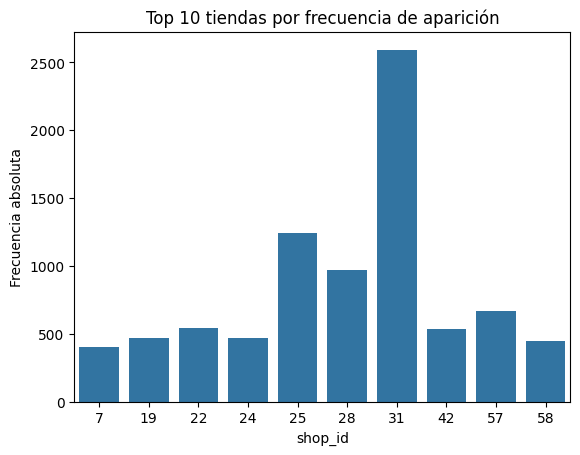

In [296]:
# Visualización
top_cities = df_features["city_id"].value_counts().head(10)
sns.barplot(x=top_cities.index, y=top_cities.values)
plt.title("Top 10 ciudades por frecuencia de aparición")
plt.xlabel("city_id")
plt.ylabel("Frecuencia absoluta")
plt.show()

top_shops = df_features["shop_id"].value_counts().head(10)
sns.barplot(x=top_shops.index, y=top_shops.values)
plt.title("Top 10 tiendas por frecuencia de aparición")
plt.xlabel("shop_id")
plt.ylabel("Frecuencia absoluta")
plt.show()

### Date

In [297]:
# Date
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df[['date', 'month', 'year', 'quarter', 'month_sin', 'month_cos']].head()

,date,month,year,quarter,month_sin,month_cos
0,2013-01-31,1,2013,1,0.5,0.866025
1,2013-01-31,1,2013,1,0.5,0.866025
2,2013-01-31,1,2013,1,0.5,0.866025
3,2013-01-31,1,2013,1,0.5,0.866025
4,2013-01-31,1,2013,1,0.5,0.866025


In [298]:
df_features["month"] = df_features["date"].dt.month
df_features["year"] = df_features["date"].dt.year
df_features["quarter"] = df_features["date"].dt.quarter

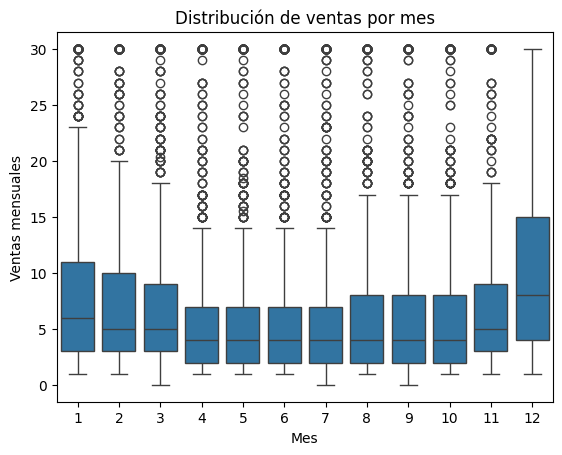

In [299]:
# Visualizacion: estacionalidad mensual
sns.boxplot(x="month", y="monthly_sales", data=df_features)
plt.title("Distribución de ventas por mes")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.show()

### AR: 1Y, 1D, 6M, 1M
 - ver como imputar nulos en los datos que nos faltan al principio de la serie


In [300]:
df_features = df_features.sort_values(["unique_id", "date"])

for lag in [1, 2, 3, 6, 12]:
    df_features[f"lag_{lag}M"] = df_features.groupby("unique_id")["monthly_sales"].shift(lag)

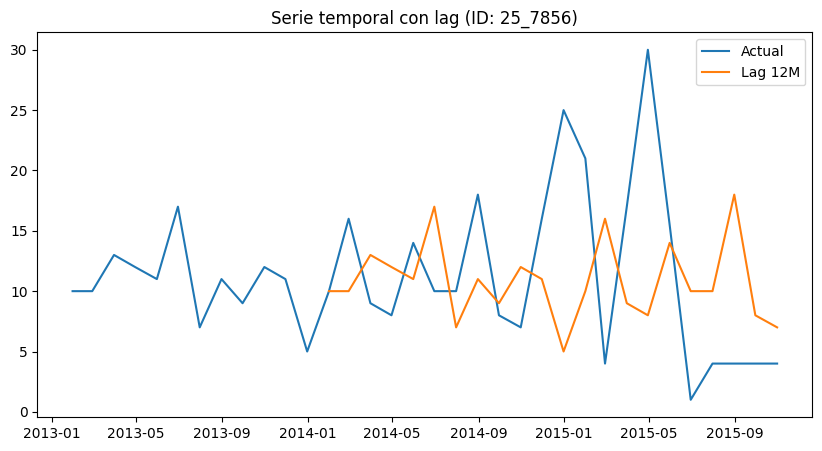

In [301]:
# Visualizacion, una serie aleatoria
example_id = np.random.choice(df_features["unique_id"].unique())
subset = df_features[df_features["unique_id"] == example_id]

plt.figure(figsize=(10,5))
plt.plot(subset["date"], subset["monthly_sales"], label="Actual")
plt.plot(subset["date"], subset["lag_12M"], label="Lag 12M")
plt.title(f"Serie temporal con lag (ID: {example_id})")
plt.legend()
plt.show()

### COUNT del item por tienda
- ver si un producto general o particular

In [302]:
item_per_shop = df_features.groupby("shop_id")["item_id"].nunique()
df_features["items_per_shop"] = df_features["shop_id"].map(item_per_shop)
df_features.head()
#df_features.tail()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,city_id_freq_enc,shop_id_freq_enc,item_id_freq_enc,month,year,quarter,lag_1M,lag_2M,lag_3M,lag_6M,lag_12M,items_per_shop
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,0.03582,0.016782,0.002397,1,2013,1,NaN,NaN,NaN,NaN,NaN,7
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,0.03582,0.016782,0.002397,2,2013,1,30.0,NaN,NaN,NaN,NaN,7
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,0.03582,0.016782,0.002397,3,2013,1,27.0,30.0,NaN,NaN,NaN,7
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,0.03582,0.016782,0.002397,4,2013,2,30.0,27.0,30.0,NaN,NaN,7
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,0.03582,0.016782,0.002397,5,2013,2,27.0,30.0,27.0,NaN,NaN,7


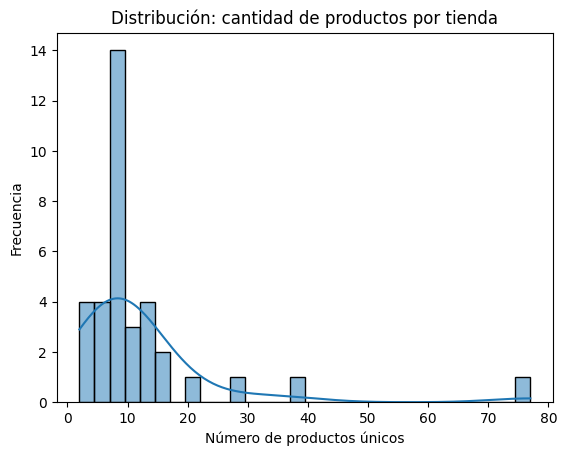

In [303]:
sns.histplot(item_per_shop, bins=30, kde=True)
plt.title("Distribución: cantidad de productos por tienda")
plt.xlabel("Número de productos únicos")
plt.ylabel("Frecuencia")
plt.show()

### COUNT de item_id por item_category
- categorias grandes vs pequeñas

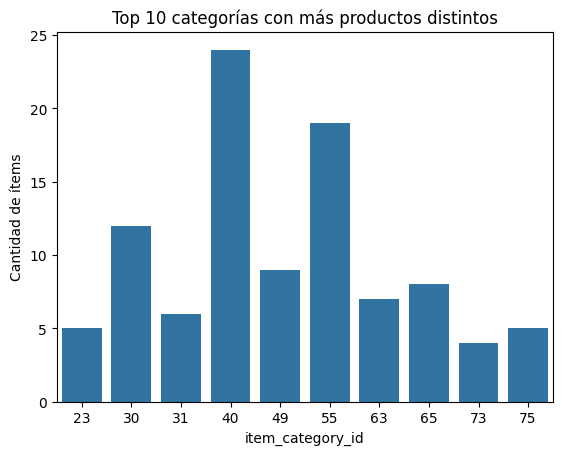

In [304]:
item_per_cat = df_features.groupby("item_category_id")["item_id"].nunique()
df_features["items_per_category"] = df_features["item_category_id"].map(item_per_cat)

top_cat = item_per_cat.sort_values(ascending=False).head(10)
sns.barplot(x=top_cat.index, y=top_cat.values)
plt.title("Top 10 categorías con más productos distintos")
plt.xlabel("item_category_id")
plt.ylabel("Cantidad de ítems")
plt.show()

### COUNT de item_id por city_id

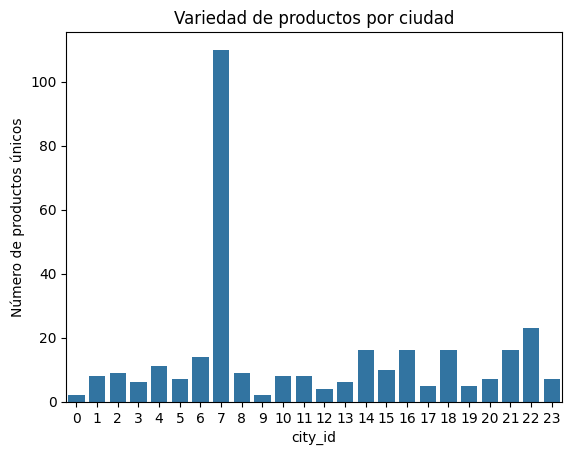

In [305]:

item_per_city = df_features.groupby("city_id")["item_id"].nunique()
df_features["items_per_city"] = df_features["city_id"].map(item_per_city)

sns.barplot(x=item_per_city.index, y=item_per_city.values, orient="v")
plt.title("Variedad de productos por ciudad")
plt.ylabel("Número de productos únicos")
plt.xlabel("city_id")
plt.show()

### COUNT de shop_id por city_id

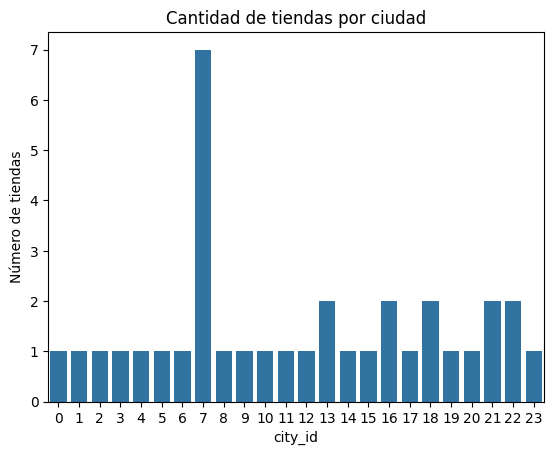

In [306]:
shops_per_city = df_features.groupby("city_id")["shop_id"].nunique()
df_features["shops_per_city"] = df_features["city_id"].map(shops_per_city)

sns.barplot(x=shops_per_city.index, y=shops_per_city.values, orient="v")
plt.title("Cantidad de tiendas por ciudad")
plt.ylabel("Número de tiendas")
plt.xlabel("city_id")
plt.show()

### Grupos caros / baratos ABC

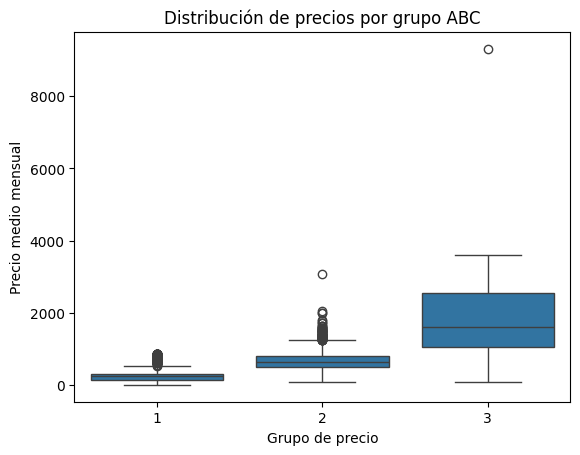

In [307]:
#Generamos clasificacion ABC respecto a precio (caro/barato) para clasificar cada item_id

price_avg = df_features.groupby("unique_id")["monthly_average_price"].mean()
price_labels = pd.qcut(price_avg, q=3, labels=[1,2,3])

df_features["price_group"] = df_features["unique_id"].map(price_labels)
df_features["price_group"] = df_features["price_group"].astype(int)


sns.boxplot(x="price_group", y="monthly_average_price", data=df_features)
plt.title("Distribución de precios por grupo ABC")
plt.xlabel("Grupo de precio")
plt.ylabel("Precio medio mensual")
plt.show()



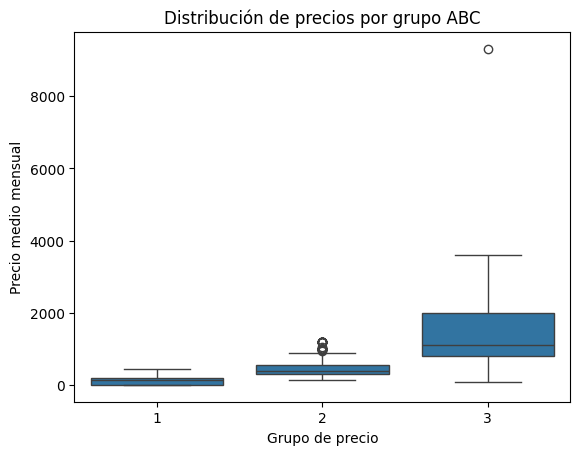

<class 'pandas.core.frame.DataFrame'>
Index: 14182 entries, 0 to 14483
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14182 non-null  datetime64[ns]
 1   unique_id              14182 non-null  object        
 2   city_id                14182 non-null  int64         
 3   shop_id                14182 non-null  int64         
 4   item_category_id       14182 non-null  int64         
 5   item_id                14182 non-null  int64         
 6   monthly_average_price  14182 non-null  float64       
 7   monthly_sales          14182 non-null  float64       
 8   city_id_freq_enc       14182 non-null  float64       
 9   shop_id_freq_enc       14182 non-null  float64       
 10  item_id_freq_enc       14182 non-null  float64       
 11  month                  14182 non-null  int32         
 12  year                   14182 non-null  int32         
 13  quarte

In [308]:
#TODO Revisar
price_avg = df_features.groupby("item_id")["monthly_average_price"].mean()
price_labels = pd.qcut(price_avg, q=3, labels=[1,2,3])

df_features["price_group"] = df_features["item_id"].map(price_labels)
df_features["price_group"] = df_features["price_group"].astype(int)

sns.boxplot(x="price_group", y="monthly_average_price", data=df_features)
plt.title("Distribución de precios por grupo ABC")
plt.xlabel("Grupo de precio")
plt.ylabel("Precio medio mensual")
plt.show()

#print(price_labels)

df_features.info()

### Grupos que se venden mucho / poco

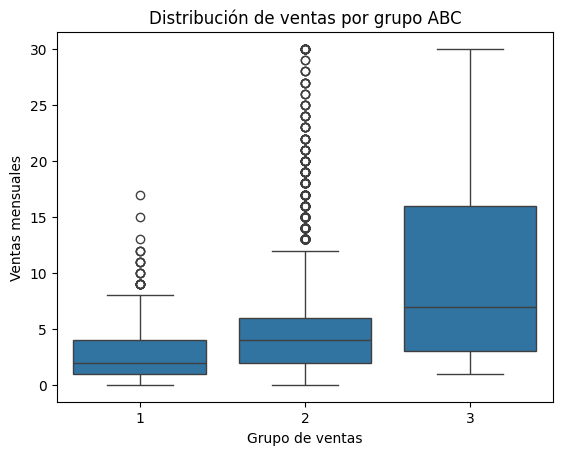

In [309]:
#TODO Filtrar los productos con ventas promedio mayores a 0 para evitar distorsiones en el análisis

sales_avg = df_features.groupby("item_id")["monthly_sales"].mean()
sales_labels = pd.qcut(sales_avg, q=3, labels=[1,2,3])

df_features["sales_group"] = df_features["item_id"].map(sales_labels)
df_features["sales_group"] = df_features["sales_group"].astype(int)

sns.boxplot(x="sales_group", y="monthly_sales", data=df_features)
plt.title("Distribución de ventas por grupo ABC")
plt.xlabel("Grupo de ventas")
plt.ylabel("Ventas mensuales")
plt.show()

In [310]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14182 entries, 0 to 14483
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14182 non-null  datetime64[ns]
 1   unique_id              14182 non-null  object        
 2   city_id                14182 non-null  int64         
 3   shop_id                14182 non-null  int64         
 4   item_category_id       14182 non-null  int64         
 5   item_id                14182 non-null  int64         
 6   monthly_average_price  14182 non-null  float64       
 7   monthly_sales          14182 non-null  float64       
 8   city_id_freq_enc       14182 non-null  float64       
 9   shop_id_freq_enc       14182 non-null  float64       
 10  item_id_freq_enc       14182 non-null  float64       
 11  month                  14182 non-null  int32         
 12  year                   14182 non-null  int32         
 13  quarte

In [311]:
df_features.sample(10)
#df_features.sales_group.value_counts()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,city_id_freq_enc,shop_id_freq_enc,...,lag_2M,lag_3M,lag_6M,lag_12M,items_per_shop,items_per_category,items_per_city,shops_per_city,price_group,sales_group
267,2013-05-31,14_7856,3,14,28,7856,799.000000,6.0,0.014032,0.014032,...,10.0,12.0,NaN,NaN,6,2,6,1,3,3
3033,2015-04-30,24_2445,7,24,30,2445,599.000000,1.0,0.444789,0.032929,...,3.0,1.0,5.0,6.0,14,12,110,7,2,3
10905,2015-09-30,50_2308,17,50,30,2308,299.000000,1.0,0.011493,0.011493,...,3.0,4.0,1.0,1.0,5,12,5,1,2,2
3912,2014-10-31,25_16147,7,25,64,16147,569.000000,1.0,0.444789,0.087505,...,5.0,2.0,3.0,2.0,37,3,110,7,2,1
2301,2014-01-31,22_13100,7,22,73,13100,1350.000000,2.0,0.444789,0.038006,...,6.0,7.0,1.0,3.0,16,4,110,7,3,2
1675,2014-11-30,19_5643,6,19,2,5643,2490.000000,1.0,0.033282,0.033282,...,1.5,2.0,2.0,6.0,14,1,14,1,3,2
3783,2014-06-30,25_5821,7,25,35,5821,649.000000,2.0,0.444789,0.087505,...,4.0,10.0,12.0,5.0,37,4,110,7,3,2
98,2014-03-31,12_11365,16,12,9,11365,1099.694152,30.0,0.035820,0.016782,...,13.0,27.0,24.0,30.0,7,4,16,2,3,3
7817,2015-05-31,31_3077,7,31,23,3077,1199.000000,1.0,0.444789,0.182837,...,4.0,2.0,6.0,5.0,77,5,110,7,3,3
8671,2013-09-30,38_5823,10,38,35,5823,2599.000000,3.0,0.019038,0.019038,...,2.0,3.0,1.0,NaN,8,4,8,1,3,3


### Imputar nulos de las columnas LAG

In [312]:
df_features["lag_1M"].fillna(-1, inplace=True)
df_features["lag_2M"].fillna(-1, inplace=True)
df_features["lag_3M"].fillna(-1, inplace=True)
df_features["lag_6M"].fillna(-1, inplace=True)
df_features["lag_12M"].fillna(-1, inplace=True)

/tmp/ipython-input-3581917281.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_features["lag_1M"].fillna(-1, inplace=True)
/tmp/ipython-input-3581917281.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [313]:
df_features.isnull().sum()

,0
date,0
unique_id,0
city_id,0
shop_id,0
item_category_id,0
item_id,0
monthly_average_price,0
monthly_sales,0
city_id_freq_enc,0
shop_id_freq_enc,0


# Seleccion de features

In [314]:
# Copia de seguridad del df
df_features2 = df_features.copy()

### Funciones

In [315]:
def build_ts_features(df, gb_list, target, agg_func):

    new_name = "_".join(gb_list + [target] + [agg_func.__name__])

    gbdf = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("ME")
        [target]
        .agg(agg_func)
        .reset_index()
    )

    gbdf[f"{new_name}_shift_1"] = (
        gbdf
        .groupby(gb_list)
        [target]
        .transform(
            lambda series: series.shift(1)
        )
    )

    gbdf[f"{new_name}_ma_3"] = (
        gbdf
        .groupby(gb_list)
        [target]
        .transform(
            lambda series: series.shift(1).rolling(window = 3).mean()
        )
    )

    gbdf.drop(target, axis = 1, inplace = True)

    df = pd.merge(
        left = df,
        right = gbdf,
        how = "left",
        on = ["date"] + gb_list
    )

    return df

In [316]:
df_back = df.copy(deep = True)
df = df_back.copy(deep = True)

In [317]:
'''
df = build_ts_features(
    df = df,
    gb_list =["item_category_id", "item_id"],
    target = "revenue",
    agg_func = np.sum
)
'''

'\ndf = build_ts_features(\n    df = df,\n    gb_list =["item_category_id", "item_id"],\n    target = "revenue",\n    agg_func = np.sum\n)\n'

### Transformaciones

In [318]:
#Reestablecemos el df
df_features2 = df_features.copy()

### Columnas a eliminar

In [319]:
#retenemos las columnas seleccionadas
def seleccionar_columnas(df, lista_columnas):
    lista_columnas.append("unique_id")
    lista_columnas.append("date")
    lista_columnas.append("monthly_sales")
    df_seleccionadas = df[lista_columnas]

    return df_seleccionadas

In [320]:
def eliminar_columnas(df, lista_columnas):
    df_sin_columnas = df.drop(columns=lista_columnas)
    return df_sin_columnas

In [321]:
list_features = ['lag_1M','lag_2M', 'item_category_id' ,'monthly_average_price', 'item_id_freq_enc' ]
#= ['lag_1M','lag_2M', 'city_id', 'item_category_id', 'item_id' ,'shop_id','monthly_average_price', 'item_id_freq_enc' ]
df_features2 = seleccionar_columnas(df_features2, list_features)

In [322]:
list_column_drop = ["item_id", "shop_id", "city_id", "item_category_id", ]
#df_features2 = eliminar_columnas(df_features2, list_column_drop)

In [323]:
df_features2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14182 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   lag_1M                 14182 non-null  float64       
 1   lag_2M                 14182 non-null  float64       
 2   item_category_id       14182 non-null  int64         
 3   monthly_average_price  14182 non-null  float64       
 4   item_id_freq_enc       14182 non-null  float64       
 5   unique_id              14182 non-null  object        
 6   date                   14182 non-null  datetime64[ns]
 7   monthly_sales          14182 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 997.2+ KB


## Model

In [324]:
all_dates = sorted(df_features2["date"].unique())

train_dates = all_dates[:-4]
test_dates = all_dates[-4:-2]
validation_dates = all_dates[-2:-1]

prediction_dates = [all_dates[-1]]

In [325]:
def get_data_splits(df, split_dates):
    X_ = (
        df[df["date"].isin(split_dates)]
        .drop(
            ["monthly_sales", "date"]
        , axis = 1
        ).set_index("unique_id")
    )

    y_ = df[df["date"].isin(split_dates)].set_index("unique_id")["monthly_sales"]

    print(split_dates)
    print(X_.shape, y_.shape)

    return X_, y_

X_train, y_train = get_data_splits(df=df_features2, split_dates=train_dates)
X_test, y_test = get_data_splits(df=df_features2, split_dates=test_dates)
X_val, y_val = get_data_splits(df=df_features2, split_dates=validation_dates)
X_pred, y_pred = get_data_splits(df=df_features2, split_dates=prediction_dates)

[Timestamp('2013-01-31 00:00:00'), Timestamp('2013-02-28 00:00:00'), Timestamp('2013-03-31 00:00:00'), Timestamp('2013-04-30 00:00:00'), Timestamp('2013-05-31 00:00:00'), Timestamp('2013-06-30 00:00:00'), Timestamp('2013-07-31 00:00:00'), Timestamp('2013-08-31 00:00:00'), Timestamp('2013-09-30 00:00:00'), Timestamp('2013-10-31 00:00:00'), Timestamp('2013-11-30 00:00:00'), Timestamp('2013-12-31 00:00:00'), Timestamp('2014-01-31 00:00:00'), Timestamp('2014-02-28 00:00:00'), Timestamp('2014-03-31 00:00:00'), Timestamp('2014-04-30 00:00:00'), Timestamp('2014-05-31 00:00:00'), Timestamp('2014-06-30 00:00:00'), Timestamp('2014-07-31 00:00:00'), Timestamp('2014-08-31 00:00:00'), Timestamp('2014-09-30 00:00:00'), Timestamp('2014-10-31 00:00:00'), Timestamp('2014-11-30 00:00:00'), Timestamp('2014-12-31 00:00:00'), Timestamp('2015-01-31 00:00:00'), Timestamp('2015-02-28 00:00:00'), Timestamp('2015-03-31 00:00:00'), Timestamp('2015-04-30 00:00:00'), Timestamp('2015-05-31 00:00:00'), Timestamp('20

In [326]:
import xgboost

model = xgboost.XGBRegressor(
    #max_depth = 4,
    #nr_estimators = 30
)

model.fit(
    X = X_train,
    y = y_train,
    eval_set = [(X_train, y_train), (X_test, y_test)],
    #early_stopping_rounds = 20
)

[0]	validation_0-rmse:6.25132	validation_1-rmse:5.59610
[1]	validation_0-rmse:5.24452	validation_1-rmse:4.46591
[2]	validation_0-rmse:4.64282	validation_1-rmse:3.72379
[3]	validation_0-rmse:4.29970	validation_1-rmse:3.30454
[4]	validation_0-rmse:4.11286	validation_1-rmse:3.07134
[5]	validation_0-rmse:3.99239	validation_1-rmse:2.94953
[6]	validation_0-rmse:3.91903	validation_1-rmse:2.89574
[7]	validation_0-rmse:3.85095	validation_1-rmse:2.87675
[8]	validation_0-rmse:3.80969	validation_1-rmse:2.84872
[9]	validation_0-rmse:3.77232	validation_1-rmse:2.83621
[10]	validation_0-rmse:3.74927	validation_1-rmse:2.83417
[11]	validation_0-rmse:3.71999	validation_1-rmse:2.82211
[12]	validation_0-rmse:3.67520	validation_1-rmse:2.82452
[13]	validation_0-rmse:3.65697	validation_1-rmse:2.82982
[14]	validation_0-rmse:3.64610	validation_1-rmse:2.84619
[15]	validation_0-rmse:3.61623	validation_1-rmse:2.84373
[16]	validation_0-rmse:3.60129	validation_1-rmse:2.84496
[17]	validation_0-rmse:3.58376	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

## Feature importance

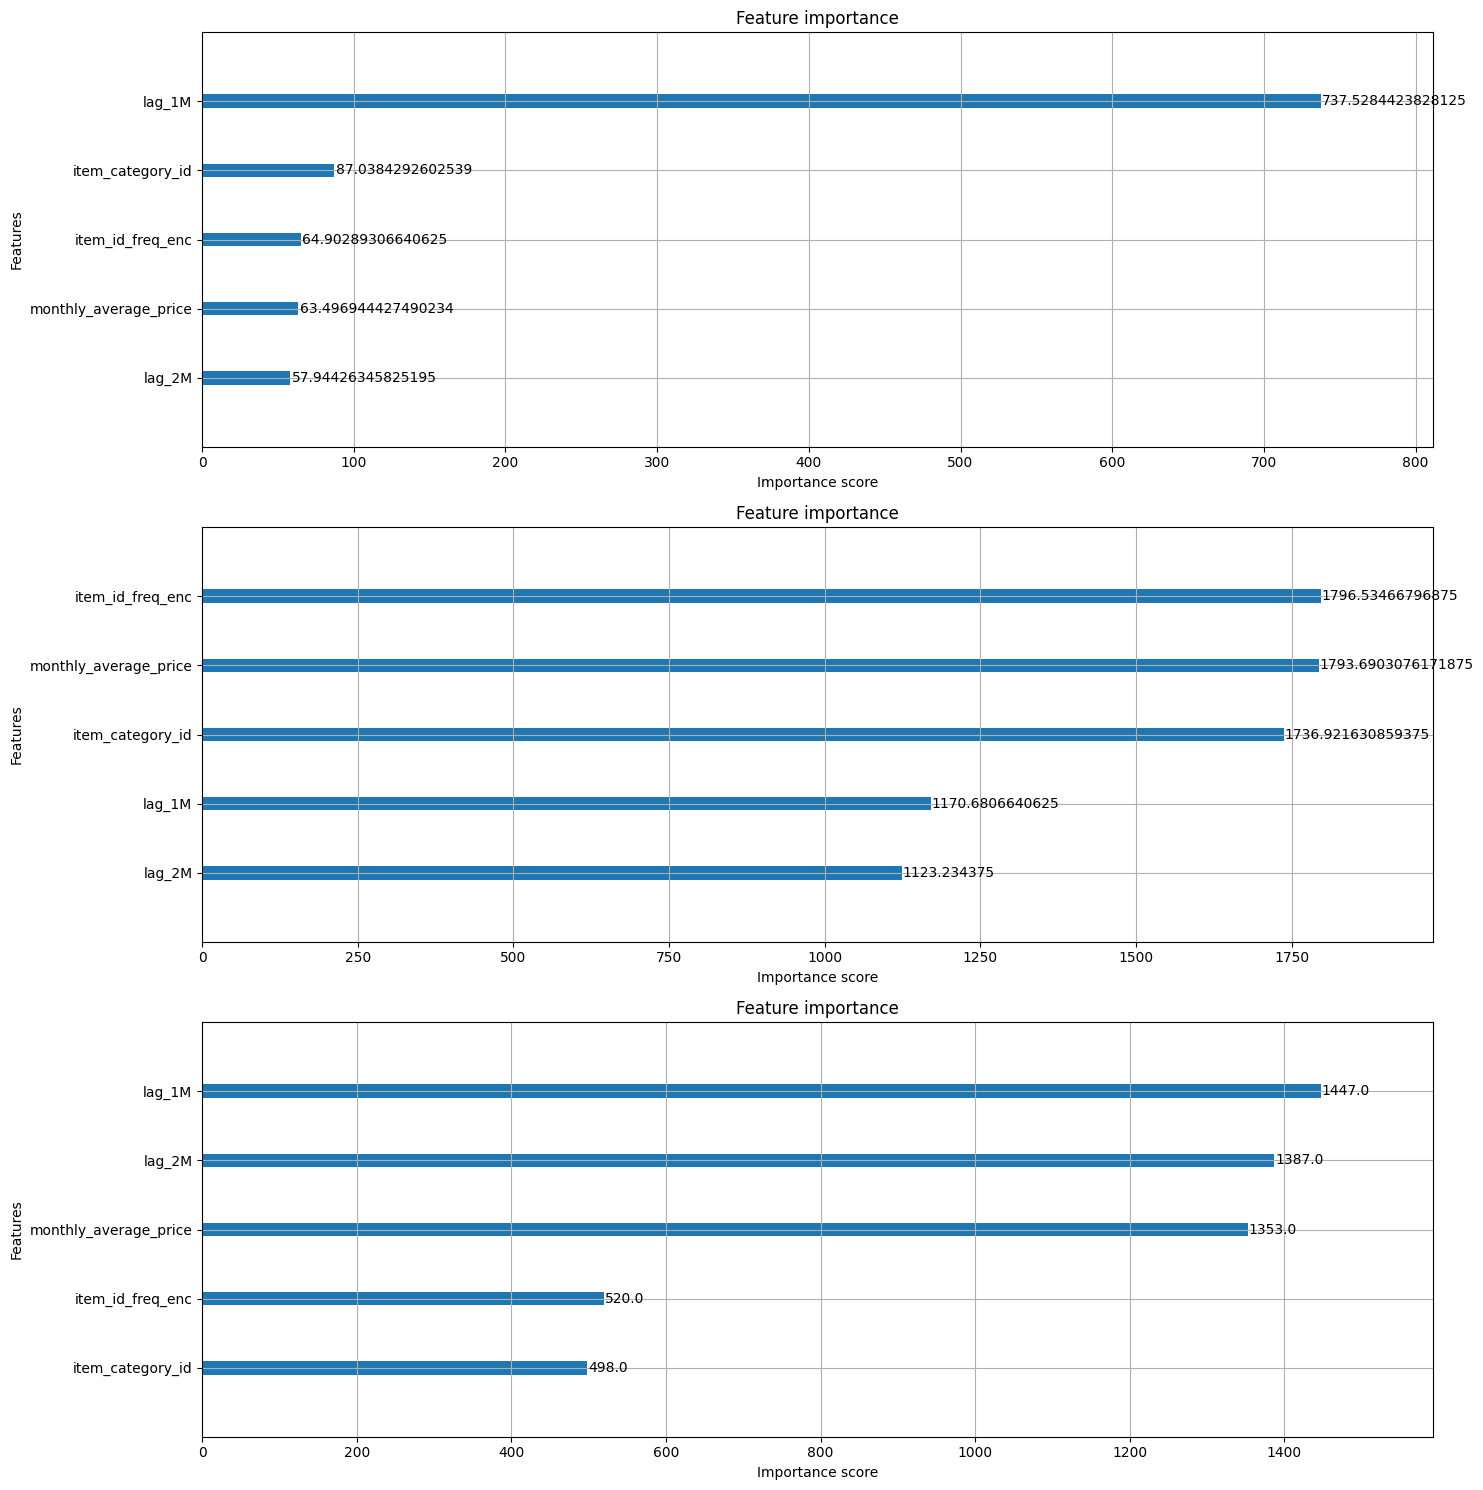

In [327]:


fig = plt.figure(figsize=(15, 15))
ax1, ax2, ax3 = fig.subplots(3, 1)

xgboost.plot_importance(booster = model, ax = ax1, importance_type = "gain")
xgboost.plot_importance(booster = model, ax = ax2, importance_type = "cover")
xgboost.plot_importance(booster = model, ax = ax3, importance_type = "weight")

plt.tight_layout();

## Model evaluation

In [328]:
from sklearn.metrics import root_mean_squared_error

In [329]:
y_train_pred = model.predict(X_train)

rmse_train = root_mean_squared_error(y_true = y_train, y_pred=y_train_pred)
rmse_train

2.9021527470831012

In [330]:
y_test_pred = model.predict(X_test)

rmse_test = root_mean_squared_error(y_true = y_test, y_pred=y_test_pred)
rmse_test

2.988823112416974

# REFACTORIZAMOS BUSQUEDA DE FEATURES

In [491]:
results = {}

In [492]:
columnas = df_features.columns
meta_data = ['unique_id', 'date', 'monthly_sales']
list_features = list(set(columnas) - set(meta_data))

In [493]:
df_features2 = df_features.copy()

In [494]:
all_dates = sorted(df_features2["date"].unique())

train_dates = all_dates[:-4]
test_dates = all_dates[-4:-2]
validation_dates = all_dates[-2:-1]

prediction_dates = [all_dates[-1]]

In [495]:
def select_features(list_features):
  import random
  #seleccionamos una cantidad random de features
  k = random.randint(4, 7)
  features_selected = random.sample(list_features, k)
  return features_selected

In [496]:
for i in range(1, 600):
  print(i)
  df_features2 = df_features.copy()

  features_selected = select_features(list_features)
  df_features2 = seleccionar_columnas(df_features2, features_selected)

  X_train, y_train = get_data_splits(df=df_features2, split_dates=train_dates)
  X_test, y_test = get_data_splits(df=df_features2, split_dates=test_dates)
#  X_val, y_val = get_data_splits(df=df_features2, split_dates=validation_dates)
#  X_pred, y_pred = get_data_splits(df=df_features2, split_dates=prediction_dates)

  model = xgboost.XGBRegressor(
    #max_depth = 4,
    #nr_estimators = 30
  )
  model.fit(
    X = X_train,
    y = y_train,
    #eval_set = [(X_train, y_train), (X_test, y_test)],
    #early_stopping_rounds = 20
  )
  y_train_pred = model.predict(X_train)
  rmse_train = root_mean_squared_error(y_true = y_train, y_pred=y_train_pred)
  y_test_pred = model.predict(X_test)
  rmse_test = root_mean_squared_error(y_true = y_test, y_pred=y_test_pred)

  results[i] = [features_selected, rmse_train, rmse_test]

1
[Timestamp('2013-01-31 00:00:00'), Timestamp('2013-02-28 00:00:00'), Timestamp('2013-03-31 00:00:00'), Timestamp('2013-04-30 00:00:00'), Timestamp('2013-05-31 00:00:00'), Timestamp('2013-06-30 00:00:00'), Timestamp('2013-07-31 00:00:00'), Timestamp('2013-08-31 00:00:00'), Timestamp('2013-09-30 00:00:00'), Timestamp('2013-10-31 00:00:00'), Timestamp('2013-11-30 00:00:00'), Timestamp('2013-12-31 00:00:00'), Timestamp('2014-01-31 00:00:00'), Timestamp('2014-02-28 00:00:00'), Timestamp('2014-03-31 00:00:00'), Timestamp('2014-04-30 00:00:00'), Timestamp('2014-05-31 00:00:00'), Timestamp('2014-06-30 00:00:00'), Timestamp('2014-07-31 00:00:00'), Timestamp('2014-08-31 00:00:00'), Timestamp('2014-09-30 00:00:00'), Timestamp('2014-10-31 00:00:00'), Timestamp('2014-11-30 00:00:00'), Timestamp('2014-12-31 00:00:00'), Timestamp('2015-01-31 00:00:00'), Timestamp('2015-02-28 00:00:00'), Timestamp('2015-03-31 00:00:00'), Timestamp('2015-04-30 00:00:00'), Timestamp('2015-05-31 00:00:00'), Timestamp('

In [497]:
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['features', 'rmse_train', 'rmse_test'])
df_results.sort_values(by='rmse_test', inplace=True)

In [498]:
df_results['rmse_test'].min()

2.934757861119662

In [499]:
df_results

,features,rmse_train,rmse_test
214,"[item_id, year, lag_2M, items_per_city, lag_3M...",2.772066,2.934758
537,"[lag_1M, item_category_id, lag_2M, shop_id, un...",3.141855,2.958240
303,"[price_group, shops_per_city, lag_1M, city_id_...",3.390058,2.988655
225,"[year, lag_2M, city_id_freq_enc, lag_1M, item_...",3.080507,3.032512
430,"[lag_3M, lag_2M, sales_group, item_id, items_p...",2.748167,3.045105
...,...,...,...
529,"[items_per_shop, shop_id_freq_enc, items_per_c...",7.578463,7.089098
312,"[quarter, city_id_freq_enc, shops_per_city, sh...",7.554385,7.134187
597,"[shop_id, quarter, city_id, shops_per_city, sh...",7.553353,7.134515
410,"[city_id, month, shop_id_freq_enc, shop_id, it...",7.480580,7.138444


## Results

In [500]:
list_features = ['lag_1M','lag_2M', 'shop_id', 'item_category_id' ,'monthly_average_price', 'item_id_freq_enc' ]
train = 2.7
test =2.89

In [501]:
list_features = ['item_id_freq_enc','lag_2M','price_group','lag_1M','monthly_average_price','lag_6M']
train = 2.8
test = 2.9

In [502]:
list_features = ['lag_1M','lag_2M', 'item_category_id' ,'monthly_average_price', 'item_id_freq_enc' ]
train = 2.902
test =2.988
